In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from src.utils import publish_model_scores
from src.datasampling import dataSampling
from src.bayesianopt import bayesianOpt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (StandardScaler, RobustScaler)
from sklearn.ensemble import (IsolationForest, RandomForestClassifier)
from sklearn.feature_selection import (mutual_info_classif, f_classif, RFE)
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv("../creditcard.csv")

# EDA

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

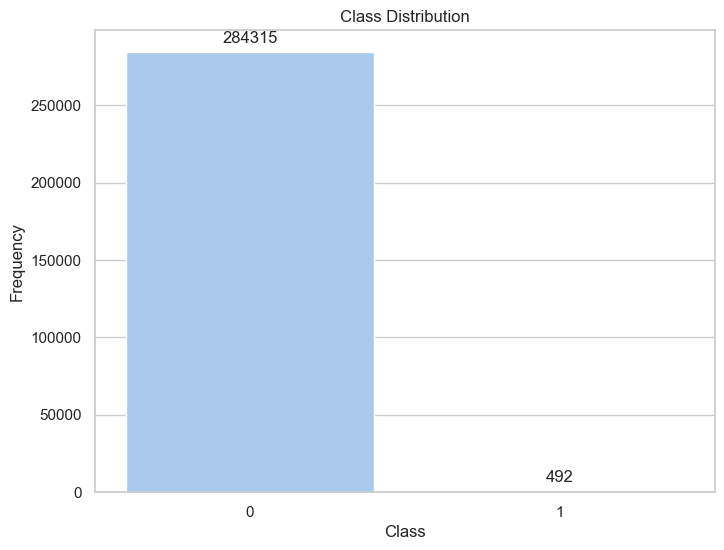


Class Distribution:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [11]:
# Class Distribution
class_distribution = df['Class'].value_counts(normalize=True)
sns.set(style="whitegrid", palette="pastel")

# Countplot to visualize the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Annotate the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

print("\nClass Distribution:\n", class_distribution)

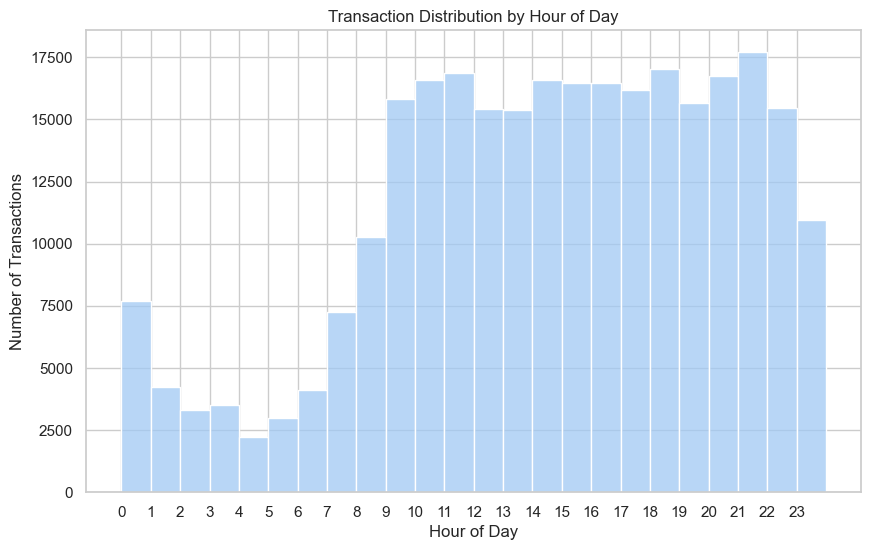

In [13]:
# Convert 'Time' from seconds to hours
df['HourOfDay'] = (df['Time'] / 3600) % 24  # This assumes 'Time' is in seconds since the start of data collection

plt.figure(figsize=(10, 6))
sns.histplot(df['HourOfDay'], bins=24, kde=False)
plt.title('Transaction Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24))
plt.show()

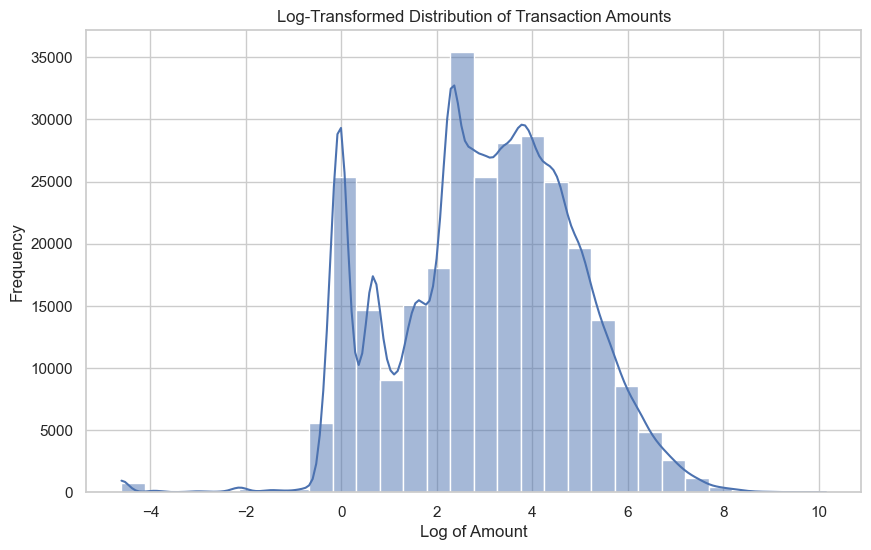

In [17]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Filter out zero or negative values and add a small constant before log transformation
amounts = df['Amount'][df['Amount'] > 0] + 1e-9  # Adding a small constant to avoid log(0)

# Create a histogram of the log-transformed 'Amount' variable using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(np.log(amounts), bins=30, kde=True)
plt.title('Log-Transformed Distribution of Transaction Amounts')
plt.xlabel('Log of Amount')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Transaction Amount Analysis
amount_stats = df['Amount'].describe()

# Time Analysis (assuming 'Time' is in seconds and we want to convert to hours for a better understanding)
time_stats = ((df['Time'] / 3600)%24).describe()

print("\nAmount Statistics:\n", amount_stats)
print("\nTime Statistics:\n", time_stats)


Amount Statistics:
 count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

Time Statistics:
 count    284807.000000
mean         14.537951
std           5.847061
min           0.000000
25%          10.598194
50%          15.010833
75%          19.329722
max          23.999444
Name: Time, dtype: float64


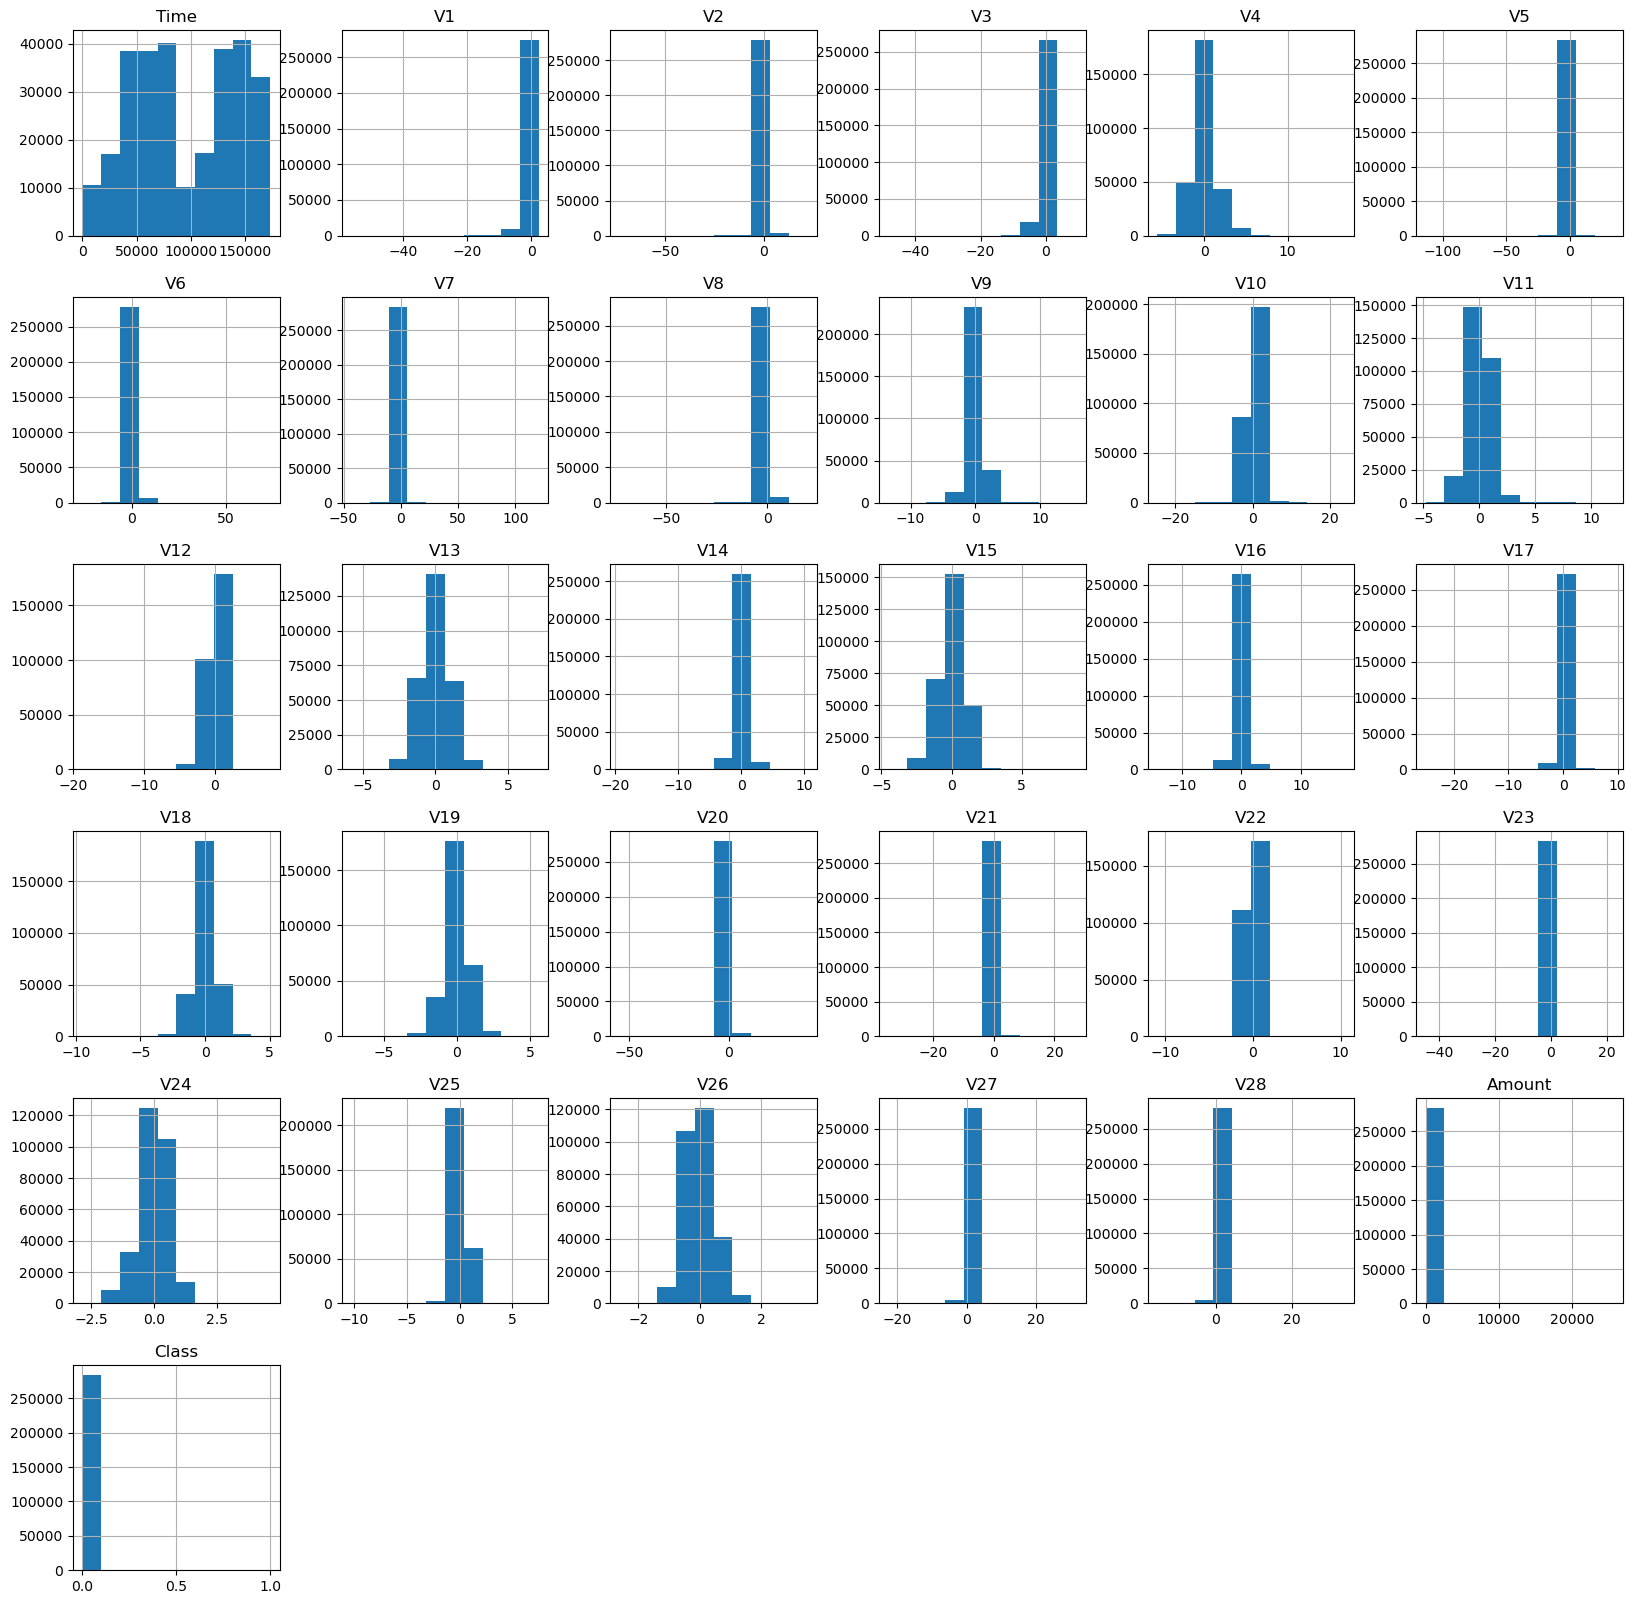

In [6]:
# Plot the histogrm
df.hist(figsize = (20, 20))
plt.show()

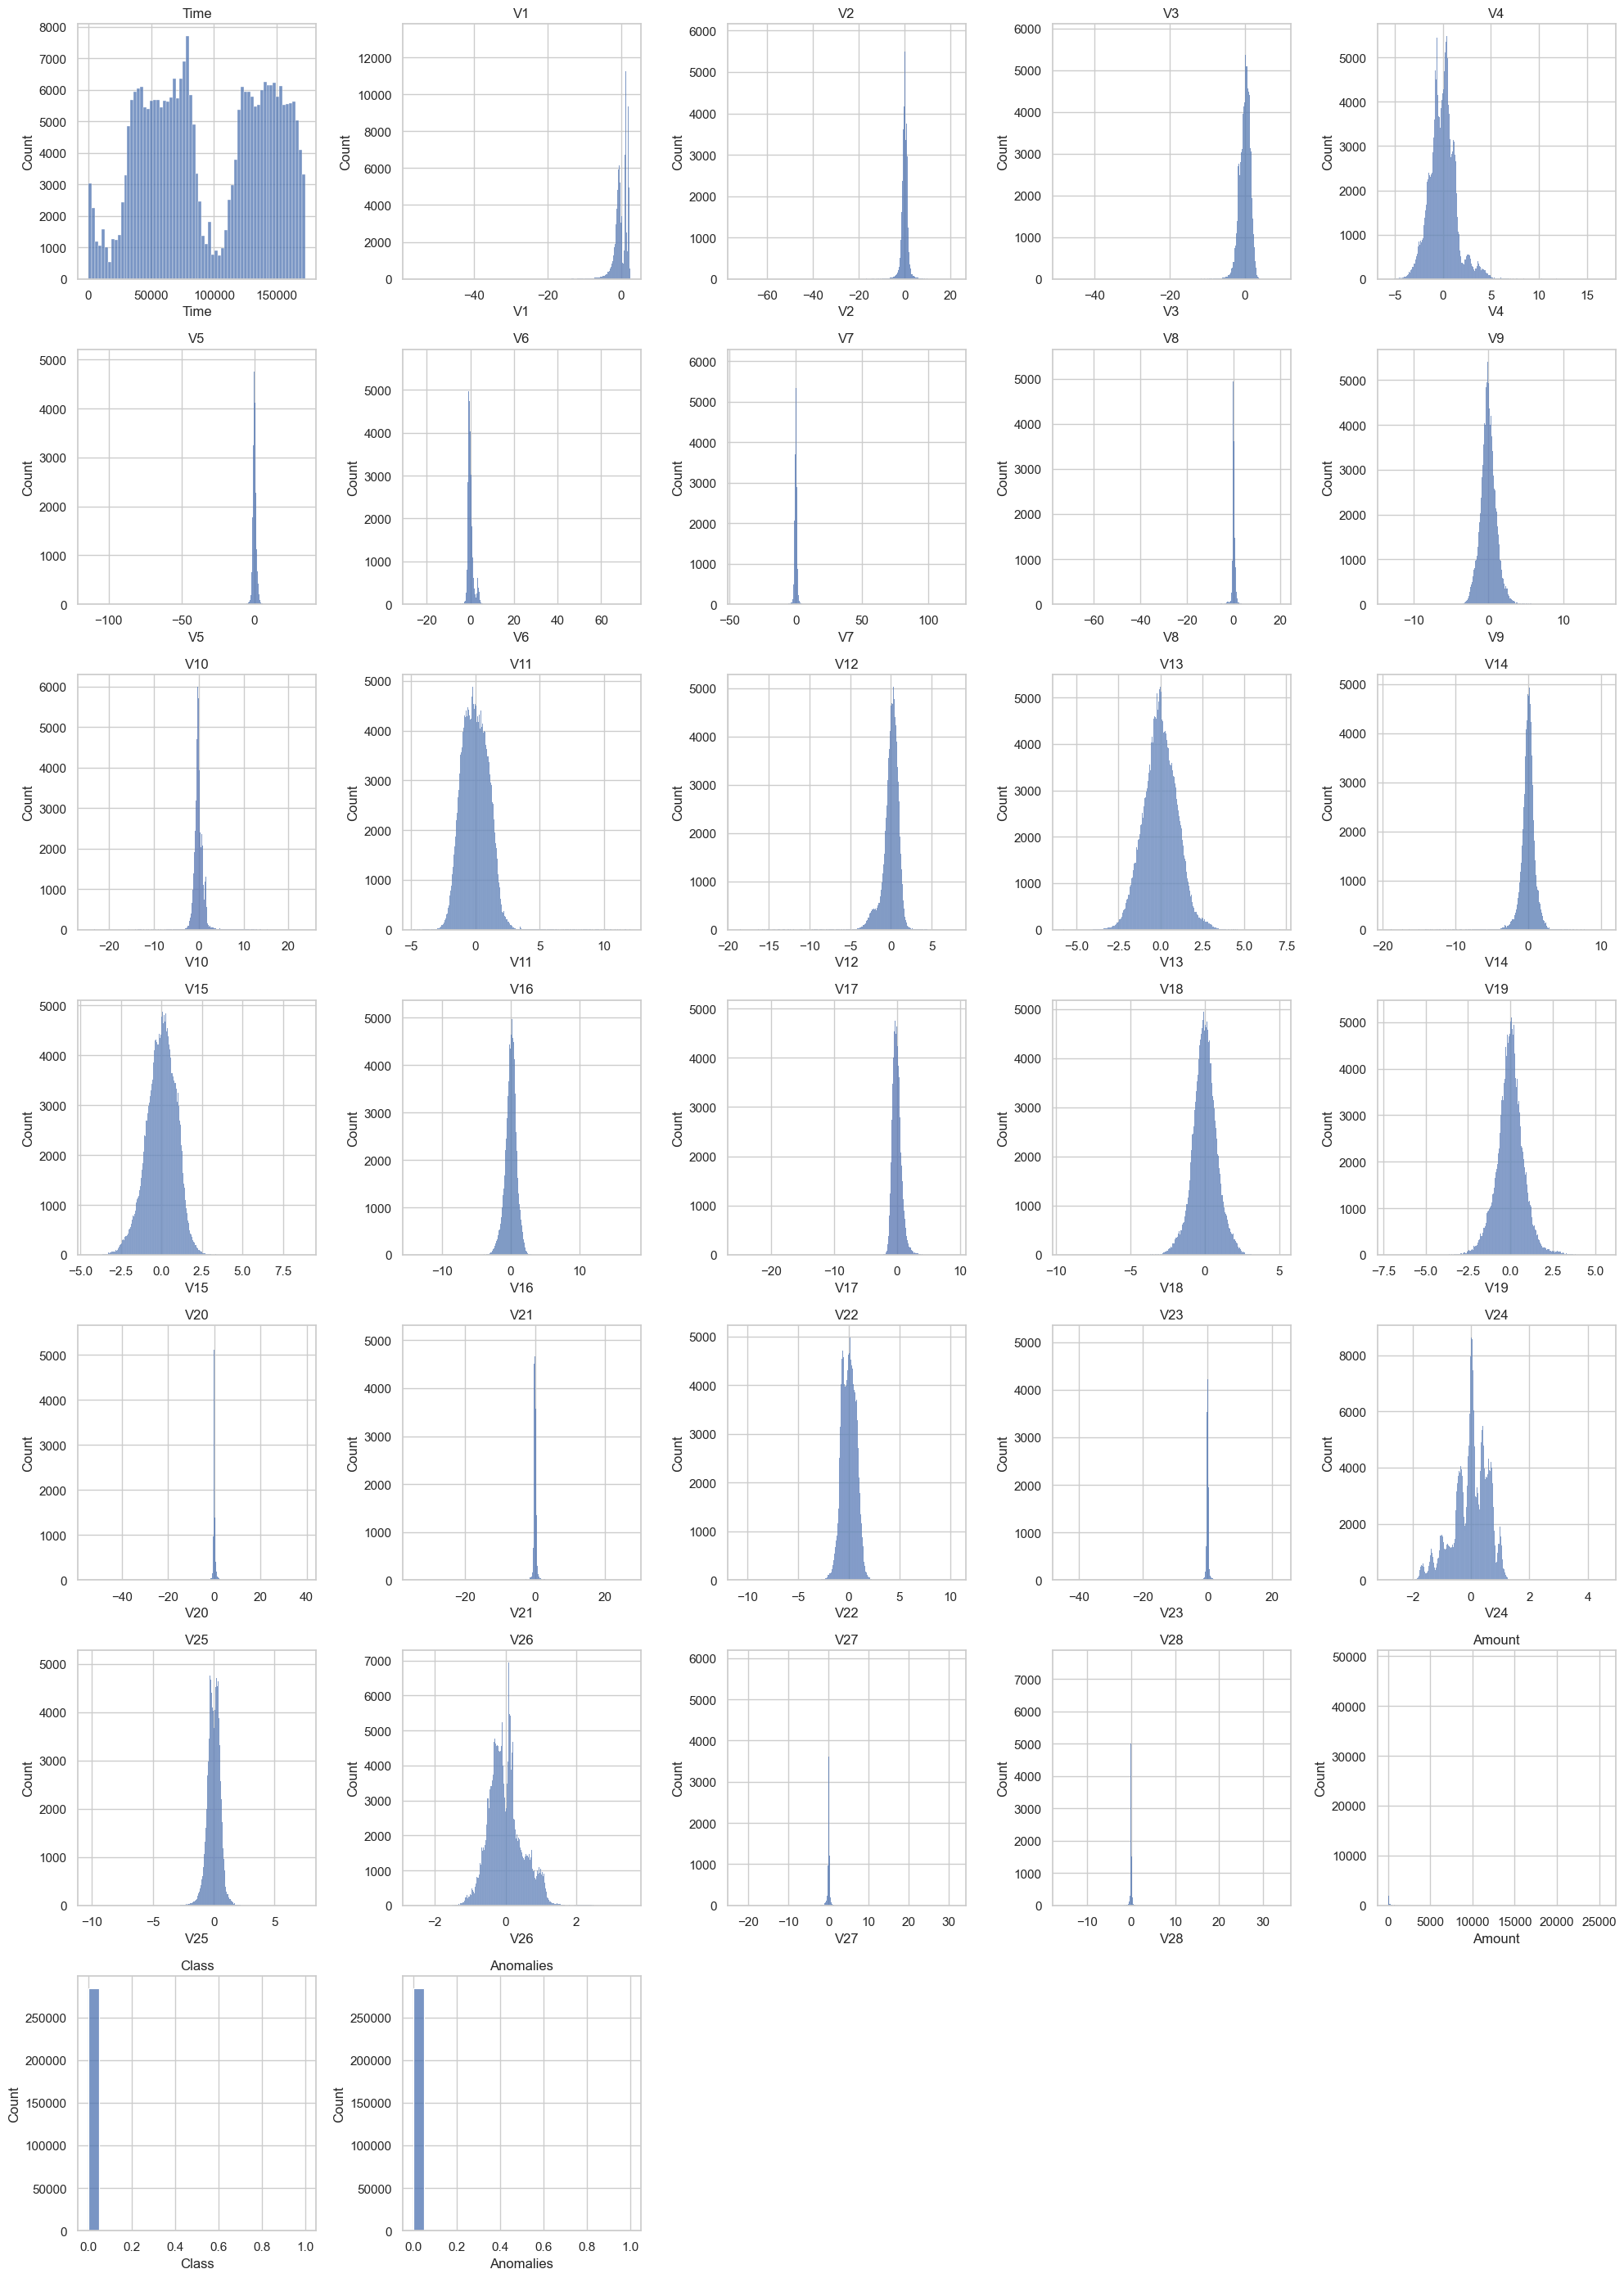

In [19]:
sns.set(style="whitegrid")

num_columns = len(df.columns)
num_rows = num_columns // 5 + (1 if num_columns % 5 else 0)  # Adjust the 4 based on how many columns per row you desire

plt.figure(figsize=(20, 4 * num_rows))  # The 4 can be adjusted based on the aspect ratio you want

for i, column in enumerate(df.columns):
    plt.subplot(num_rows, 5, i + 1)  # Adjust the 4 to match the number of columns per row
    sns.histplot(df[column], kde=False)
    plt.title(column)

plt.tight_layout()
plt.show()

Features are scaled so need not to do any standard transformation for preprocessing

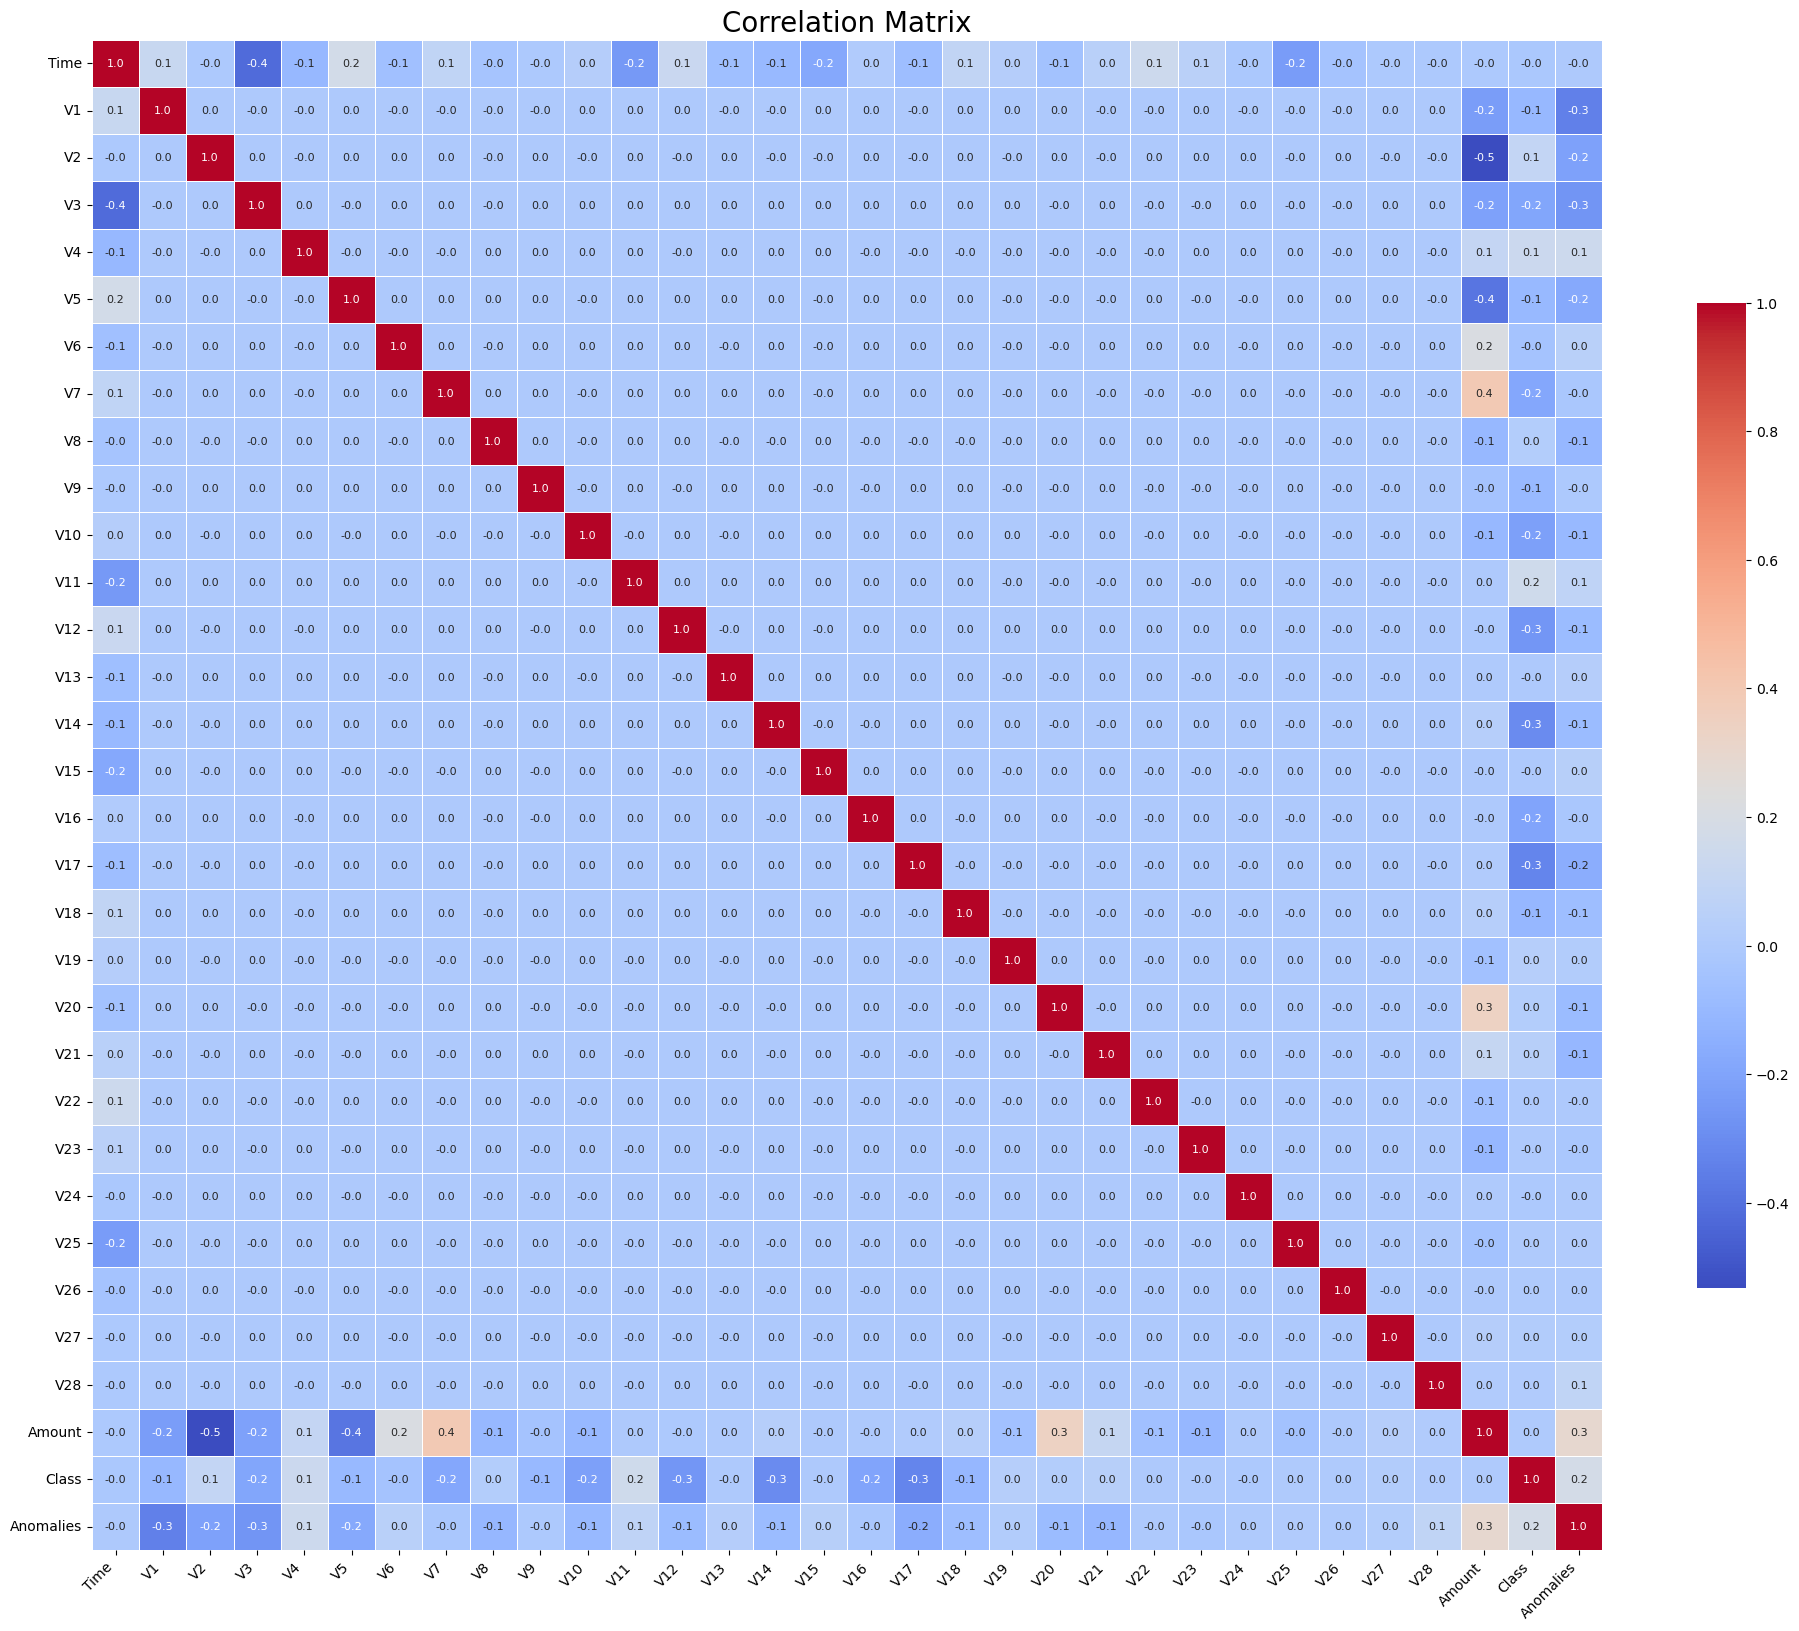

In [16]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 20))

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".1f", 
            cmap='coolwarm',
            linewidths=0.5,
            cbar_kws={"shrink": 0.5},
            square=True,  
            annot_kws={"size": 8})  

plt.title('Correlation Matrix', size=20)
plt.xticks(rotation=45, ha='right', size=10)  
plt.yticks(rotation=0, size=10)  
plt.tight_layout()  
plt.show()


There is no significant correlation amoung the data so no need for reducing highly correlated data

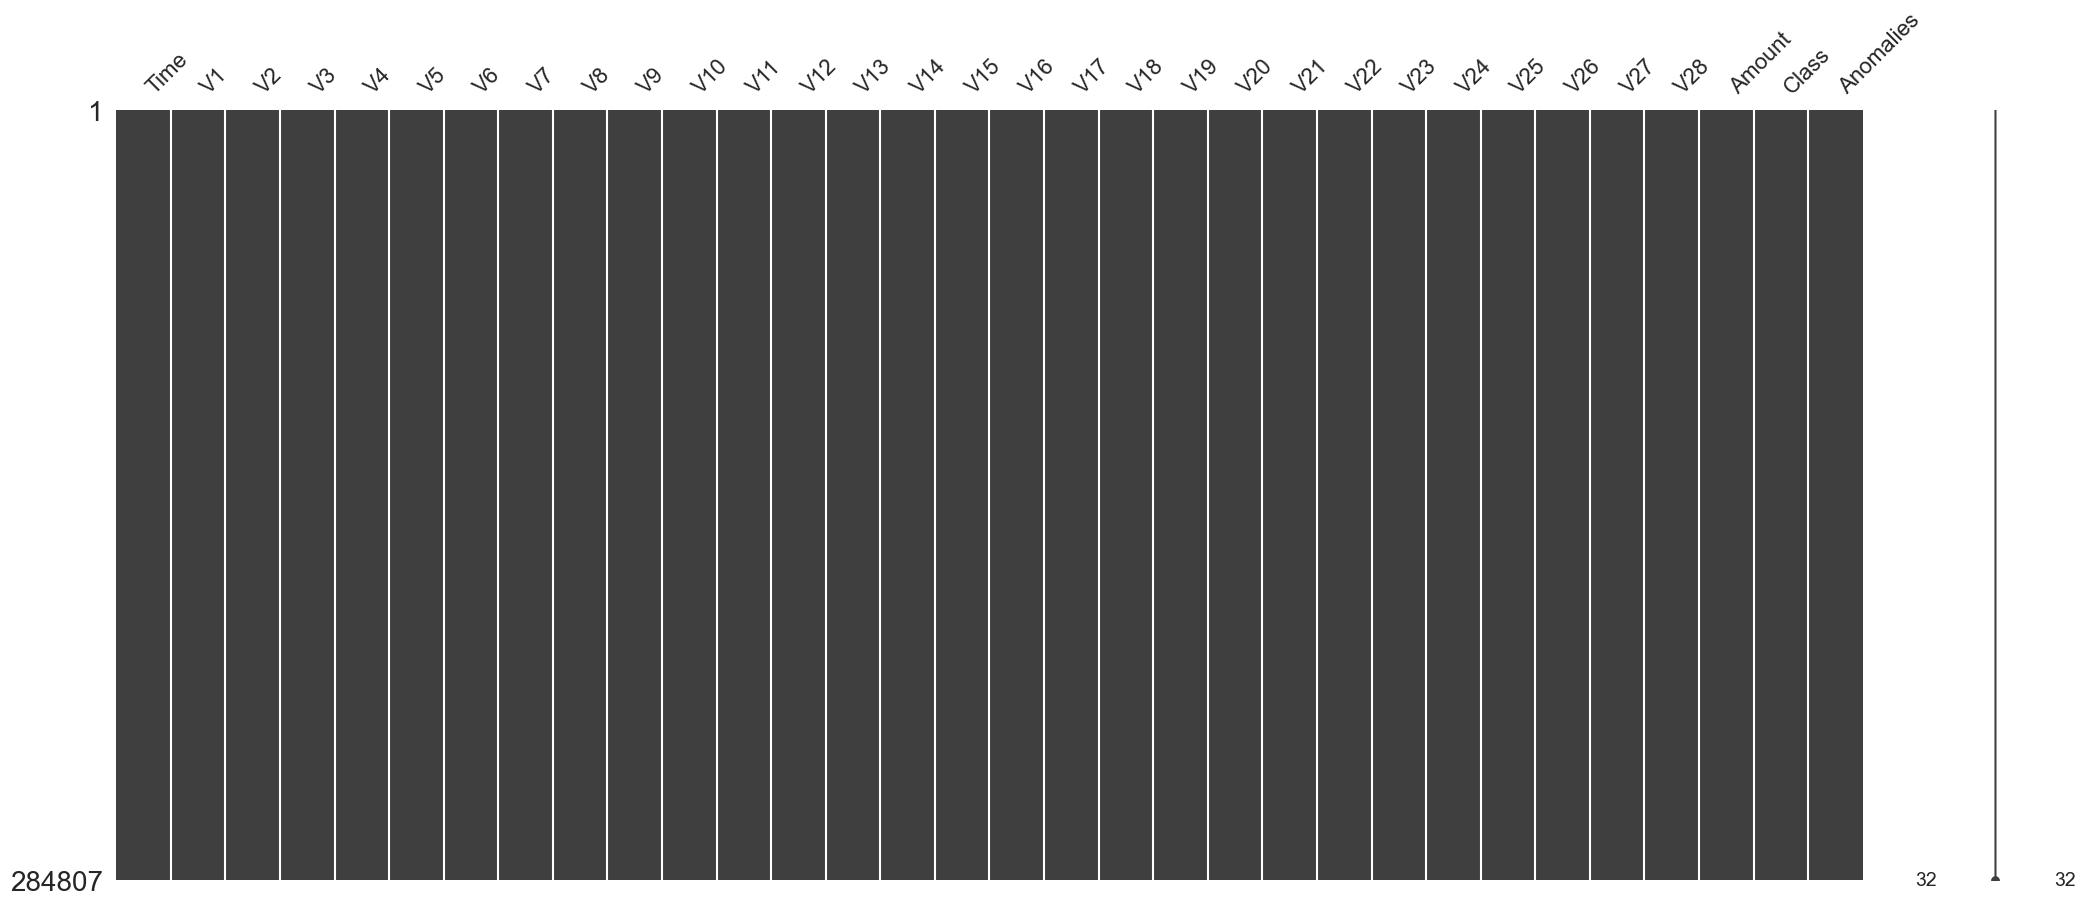

<Figure size 1500x900 with 0 Axes>

In [20]:
# Checking for missing values
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

No missing data, so no requirements for imputation or usage of other methods to handle missing data.

# ANOMALY DETECTION (via isolation Forests)

In [9]:
X = df.drop(['Class'], axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the Isolation Forest model. The contamination parameter should reflect the proportion of fraud cases
iso_forest = IsolationForest(n_estimators=100, contamination=float(np.sum(y == 1)) / len(y))

iso_forest.fit(X_scaled)

# Predict anomalies (1 for inliers, -1 for outliers)
anomalies = iso_forest.predict(X_scaled)

# Convert the predictions to match the 'Class' labels (0 for inliers, 1 for outliers)
anomalies = np.where(anomalies == 1, 0, 1)

df['Anomalies'] = anomalies

In [10]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Anomalies
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


In [11]:
print(classification_report(df['Class'], df['Anomalies']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.18      0.18      0.18       492

    accuracy                           1.00    284807
   macro avg       0.59      0.59      0.59    284807
weighted avg       1.00      1.00      1.00    284807



The classification report indicates that:

- The model has perfect precision, recall, and F1-score for the majority class (0), suggesting it identifies non-fraudulent transactions flawlessly.
- The precision, recall, and F1-score for the minority class (1) are all 0.29, indicating that the model is not performing well on the fraudulent transactions. It’s likely that many fraudulent transactions are either not being caught (low recall) or many non-fraudulent transactions are incorrectly being labeled as fraud (low precision).
- The accuracy is perfect, but this is misleading due to the severe class imbalance; the model could be simply predicting everything as the majority class.
- The macro average is 0.64, which isn't high, reflecting the poor performance on the minority class.
- The weighted average F1-score is perfect due to the imbalance heavily weighting the majority class’s performance.

The next steps could involve improving the model’s ability to detect the minority class by trying different models, resampling the data, or using different feature selection methods. It’s also important to focus on metrics beyond accuracy, such as the F1-score or AUC-PR, which are more informative for imbalanced datasets.

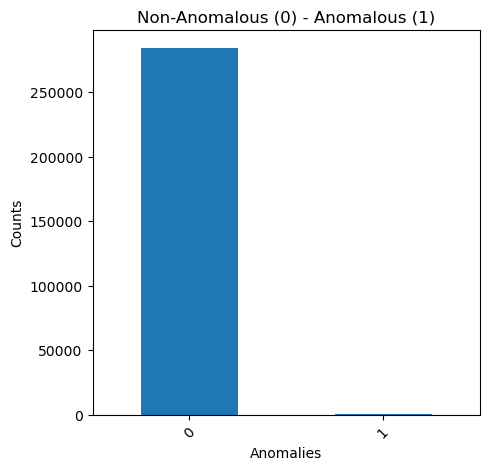

In [12]:
ano = df['Anomalies'].value_counts()

plt.figure(figsize=(5, 5))
ano.plot(kind='bar')
plt.title('Non-Anomalous (0) - Anomalous (1)')
plt.xlabel('Anomalies')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

# FEATURE ENGINEERING

In [13]:
# time based features

def time_to_hour(time_in_seconds):
    return (time_in_seconds // (60 * 60)) % 24

df['HourOfDay'] = df['Time'].apply(time_to_hour)
df['Weekend'] = (df['HourOfDay'] >= 0) & (df['HourOfDay'] < 6)
df['Weekend'] = df['Weekend'].apply(lambda x: 1 if x else 0)

In [14]:
# amount based features

df['Log_Amount'] = np.log(df['Amount'] + 1e-9)  # Adding a small constant to avoid log(0)

# Amount bins
# Define bins for transaction amount
bins = [0, 25, 50, 75, 100, 125, 150, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7]  # These are arbitrary labels for the bins
df['Amount_bin'] = pd.cut(df['Amount'], bins=bins, labels=labels)

In [15]:
# standardization of OG time and amount
scaler = StandardScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['scaled_HourOfDay'] = scaler.fit_transform(df['HourOfDay'].values.reshape(-1,1))
df['scaled_Log_Amount'] = scaler.fit_transform(df['Log_Amount'].values.reshape(-1,1))
df['scaled_Amount_bin'] = scaler.fit_transform(df['Amount_bin'].values.reshape(-1,1))


df.drop(['Time','Amount', 'HourOfDay', 'Log_Amount', 'Amount_bin'], axis=1, inplace=True)

In [16]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V27,V28,Class,Anomalies,Weekend,scaled_amount,scaled_time,scaled_HourOfDay,scaled_Log_Amount,scaled_Amount_bin
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.133558,-0.021053,0,0,1,0.244964,-1.996583,-2.40693,0.811088,1.578701
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.008983,0.014724,0,0,1,-0.342475,-1.996583,-2.40693,-0.701392,-0.722044
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.055353,-0.059752,0,0,1,1.160686,-1.996562,-2.40693,1.160566,2.038850
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.062723,0.061458,0,0,1,0.140534,-1.996562,-2.40693,0.738878,1.118552
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.219422,0.215153,0,0,1,-0.073403,-1.996541,-2.40693,0.525139,0.198254


In [17]:
nan_columns = df.columns[df.isnull().any()]
print(nan_columns)

Index(['scaled_Amount_bin'], dtype='object')


In [18]:
# Assuming 'df' is your DataFrame and 'column_name' is the name of the column
num_nan_rows = df['scaled_Amount_bin'].isnull().sum()
num_nan_rows


1825

In [19]:
df['scaled_Amount_bin'] = df['scaled_Amount_bin'].fillna(0)

# FEATURE SELECTION

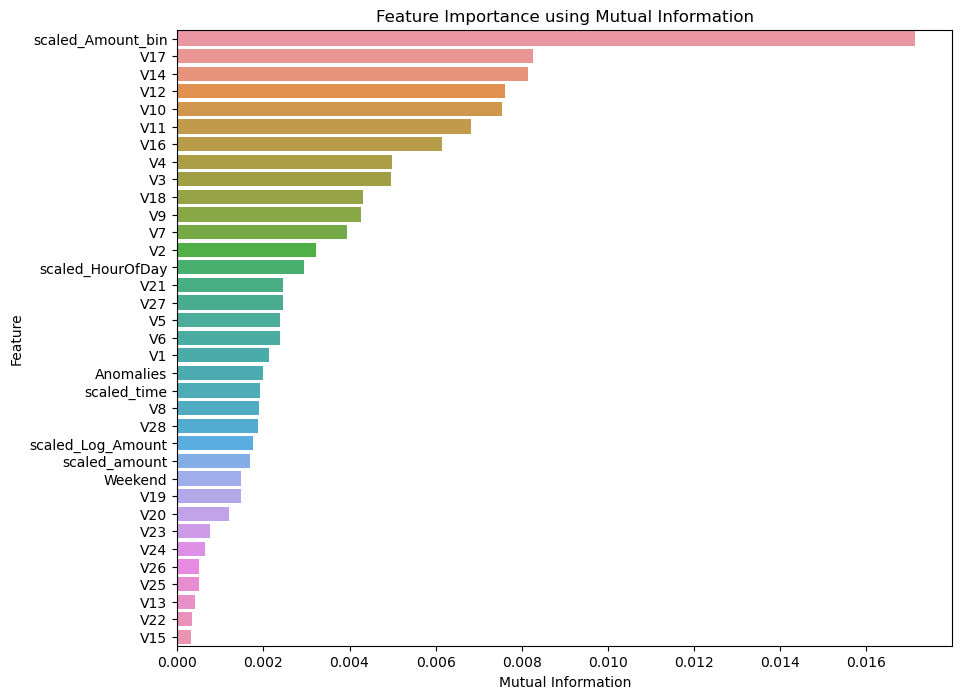

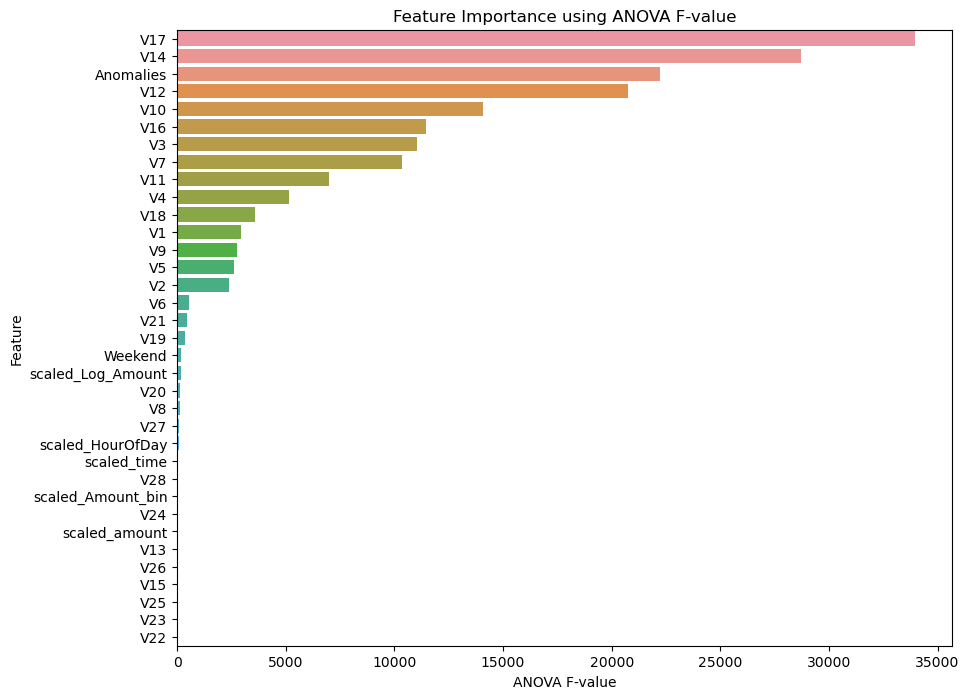

In [20]:
X = df.drop('Class', axis=1)
y = df['Class']

# Calculate mutual information
mi = mutual_info_classif(X, y)
# Calculate ANOVA F-values
f_scores, p_values = f_classif(X, y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi,
    'ANOVA F-value': f_scores,
    'p-value': p_values
})

# Plotting the Mutual Information scores
plt.figure(figsize=(10, 8))
sns.barplot(x='Mutual Information', y='Feature', data=feature_scores.sort_values(by='Mutual Information', ascending=False))
plt.title('Feature Importance using Mutual Information')
plt.show()

# Plotting the ANOVA F-values
plt.figure(figsize=(10, 8))
sns.barplot(x='ANOVA F-value', y='Feature', data=feature_scores.sort_values(by='ANOVA F-value', ascending=False))
plt.title('Feature Importance using ANOVA F-value')
plt.show()

In [21]:
# # Define a threshold for feature importance, for example, features in the bottom 10% of both methods
# threshold_mi = feature_scores['Mutual Information'].quantile(0.25)
# threshold_f = feature_scores['ANOVA F-value'].quantile(0.25)

# # Identify low importance features from both Mutual Information and ANOVA F-value
# low_importance_features = feature_scores[
#     (feature_scores['Mutual Information'] <= threshold_mi) &
#     (feature_scores['ANOVA F-value'] <= threshold_f)
# ]['Feature'].tolist()

In [22]:
anova_threshold = 1000  

# Identify features that fall below this threshold
features_to_remove = feature_scores[feature_scores['ANOVA F-value'] < anova_threshold]['Feature'].tolist()

In [23]:
features_to_remove


['V6',
 'V8',
 'V13',
 'V15',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Weekend',
 'scaled_amount',
 'scaled_time',
 'scaled_HourOfDay',
 'scaled_Log_Amount',
 'scaled_Amount_bin']

In [24]:
df = df.drop(columns=features_to_remove)

In [25]:
# columns_to_drop = ['V23', 'V22', 'V25', 'V15', 'V26', 'V13', 'V24', 'V28', 'V27', 'V8', 'V20', 'V19', 'V21', 'V6']
# df = df.drop(columns=columns_to_drop)

In [26]:
df.head()

,V1,V2,V3,V4,V5,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class,Anomalies
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   V1         284807 non-null  float64
 1   V2         284807 non-null  float64
 2   V3         284807 non-null  float64
 3   V4         284807 non-null  float64
 4   V5         284807 non-null  float64
 5   V7         284807 non-null  float64
 6   V9         284807 non-null  float64
 7   V10        284807 non-null  float64
 8   V11        284807 non-null  float64
 9   V12        284807 non-null  float64
 10  V14        284807 non-null  float64
 11  V16        284807 non-null  float64
 12  V17        284807 non-null  float64
 13  V18        284807 non-null  float64
 14  Class      284807 non-null  int64  
 15  Anomalies  284807 non-null  int64  
dtypes: float64(14), int64(2)
memory usage: 34.8 MB


In [28]:
df.isnull().values.any()

False

# 1 Evaluate Logistic Regression Classifier without sampling techniques

# 1.1 Get the data

In [29]:
# Make a data source object using dataSampling class
ds = dataSampling(df,"Class",0.30,42,True,True)

In [30]:
# Make in-smaple and out sample dataset without sampling
X_train,X_test,y_train,y_test = ds.get_data_without_sample()
ds.print_class_percentage(X_train,X_test,y_train,y_test)

=====Train class count=====
Class
0    199020
1       344
Name: count, dtype: int64
Class
0    0.998275
1    0.001725
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 1.2 Fit the Logistic Regression Classifier and optimize Hyperparameters using Bayesian Optimization

In [32]:
# Specified the parameters
# param_grid = {'criterion':['gini','entropy'],
#               'max_depth': np.arange(1,15),
#               "max_features": ['sqrt', 'log2'],
#               "min_samples_split": range(2,21),
#               "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
#               "cv":[2],
#               "scoring":["f1_macro"],
#               "n_jobs":[-1]}

parameters = {'solver': ['saga'],
              'penalty':['l1', 'l2'],
              'C':np.logspace(-3, 300, 30),
              "cv":[2],
              "scoring":["f1_macro"],
              "n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":30}

# Fit and Optimize the Baysian model
dt_opt = bayesianOpt(LogisticRegression(random_state = 0))
best_model = dt_opt.optimize_fit(X_train,y_train,parameters,conf_dict)

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshk

# 1.3 See the performance on unseen data

In [33]:
dt_opt.optimize_results["best_params"]

{'solver': 'saga',
 'scoring': 'f1_macro',
 'penalty': 'l2',
 'n_jobs': -1,
 'cv': 2,
 'C': 4.175318936560392e+174}

In [34]:
print("------Training model Results------")
publish_model_scores(X_train,y_train,best_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_model)

------Training model Results------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.91      0.62      0.74       344

    accuracy                           1.00    199364
   macro avg       0.95      0.81      0.87    199364
weighted avg       1.00      1.00      1.00    199364

ROC_AUC Score 0.9818823718780163
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.57      0.69       148

    accuracy                           1.00     85443
   macro avg       0.92      0.79      0.84     85443
weighted avg       1.00      1.00      1.00     85443

ROC_AUC Score 0.9724974373517665


# 2. Evaluate using under sampling (near miss) method

# 2.1 Get the data

In [35]:
X_nm_train,X_test,y_nm_train,y_test= ds.get_data_near_miss()
ds.print_class_percentage(X_nm_train,X_test,y_nm_train,y_test)

=====Train class count=====
Class
0    3440
1     344
Name: count, dtype: int64
Class
0    0.909091
1    0.090909
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 2.2 Fit the Descion Tree Classifier and optimize Hyperparameters using Bayesian Optimization

In [36]:
# Specified the parameters
# param_grid = { 'criterion':['gini','entropy'],
#               'max_depth': np.arange(1,15),
#               "max_features": ['sqrt', 'log2'],
#               "min_samples_split": range(2,21),
#               "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
#               "cv":[2],"scoring":["f1_macro"],"n_jobs":[-1]}

param_grid = {'solver': ['saga'],
              'penalty':['l1', 'l2'],
              'C':np.logspace(-3, 300, 30),
              "cv":[2],
              "scoring":["f1_macro"],
              "n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":30}

# Fit and Optimize the Baysian model
dt_nm_opt = bayesianOpt(LogisticRegression(random_state = 0))
best_nm_model = dt_nm_opt.optimize_fit(X_nm_train,y_nm_train,param_grid,conf_dict)

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshk

# 2.3 See the performance on unseen data

In [37]:
print("------Training model Results------")
publish_model_scores(X_nm_train,y_nm_train,best_nm_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_nm_model)

------Training model Results------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3440
           1       0.99      0.88      0.93       344

    accuracy                           0.99      3784
   macro avg       0.99      0.94      0.96      3784
weighted avg       0.99      0.99      0.99      3784

ROC_AUC Score 0.9813995740941049
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     85295
           1       0.01      0.88      0.02       148

    accuracy                           0.85     85443
   macro avg       0.50      0.86      0.47     85443
weighted avg       1.00      0.85      0.92     85443

ROC_AUC Score 0.9230060061820422


# 3. Evaluate using under sampling (SMOTE) method
# 3.1 Get the data sets using SMOTE sampling technique

In [38]:
X_sm_train,X_test,y_sm_train,y_test= ds.get_data_smote()
ds.print_class_percentage(X_sm_train,X_test,y_sm_train,y_test)

=====Train class count=====
Class
0    199020
1    199020
Name: count, dtype: int64
Class
0    0.5
1    0.5
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 3.2 Fit the data and tune the hyperparametres using Bayesian Optimization

In [40]:
# Specified the parameters
# param_grid = { 'criterion':['gini','entropy'],
#               'max_depth': np.arange(1,15),
#               "max_features": ['sqrt', 'log2'],
#               "min_samples_split": range(2,21),
#               "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
#               "cv":[2],"scoring":["f1_macro"],"n_jobs":[-1]}

param_grid = {'solver': ['saga'],
              'penalty':['l1', 'l2'],
              'C':np.logspace(-3,300,30),
              "cv":[2],
              "scoring":["f1_macro"],
              "n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":30}

# Fit and Optimize the Baysian model
dt_sm_opt = bayesianOpt(LogisticRegression(random_state = 0))
best_sm_model = dt_sm_opt.optimize_fit(X_sm_train,y_sm_train,param_grid,conf_dict)

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshkrishnan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/atheeshk

KeyboardInterrupt: 

# 3.3 Evaluate the Performance

In [ ]:
print("------Training model Results------")
publish_model_scores(X_sm_train,y_sm_train,best_sm_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_sm_model)

------Training model Results------
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    199020
           1       0.97      0.90      0.93    199020

    accuracy                           0.94    398040
   macro avg       0.94      0.94      0.94    398040
weighted avg       0.94      0.94      0.94    398040

ROC_AUC Score 0.9843936727003821
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.89      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.93      0.54     85443
weighted avg       1.00      0.97      0.98     85443

ROC_AUC Score 0.9816854224527592


# 4 Evaluate Performance using Random Over Sampling Methods
# 4.1 Get the dataset using ramdom over sampling method

In [ ]:
X_rn_train,X_test,y_rn_train,y_test= ds.get_data_random_over_sample()
ds.print_class_percentage(X_rn_train,X_test,y_rn_train,y_test)

=====Train class count=====
Class
0    199020
1    199020
Name: count, dtype: int64
Class
0    0.5
1    0.5
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 4.2 Fit the data and tune the hyperparametres using Bayesian Optimization

In [ ]:
# Specified the parameters
# param_grid = { 'criterion':['gini','entropy'],
#               'max_depth': np.arange(1,15),
#               "max_features": ['sqrt', 'log2'],
#               "min_samples_split": range(2,21),
#               "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
#               "cv":[2],"scoring":["f1_macro"],"n_jobs":[-1]}

param_grid = {'solver': ['saga'],
              'penalty':['l1', 'l2'],
              'C':[0.1,100],
              "cv":[2],
              "scoring":["f1_macro"],
              "n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
dt_rn_opt = bayesianOpt(LogisticRegression(random_state = 0))
best_rn_model = dt_rn_opt.optimize_fit(X_sm_train,y_sm_train,param_grid,conf_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

# 4.3 Evaluate the Performance on unseen data

In [ ]:
print("------Training model Results------")
publish_model_scores(X_rn_train,y_rn_train,best_rn_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_rn_model)

------Training model Results------
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    199020
           1       0.97      0.91      0.94    199020

    accuracy                           0.94    398040
   macro avg       0.94      0.94      0.94    398040
weighted avg       0.94      0.94      0.94    398040

ROC_AUC Score 0.9801433304722635
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.05      0.89      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.93      0.54     85443
weighted avg       1.00      0.97      0.98     85443

ROC_AUC Score 0.9816854224527592


# SHAP ANALYSIS

In [ ]:
import shap

clf = LogisticRegression()
clf.fit(X_nm_train, y_nm_train)

explainer = shap.Explainer(clf, X_nm_train)

shap_values = explainer(X_test)

# Indexing for the positive class SHAP values (which is typically at index 1)
positive_class_shap_values = shap_values #[..., 1]

In [ ]:
print(shap_values.shape)


(85443, 15)


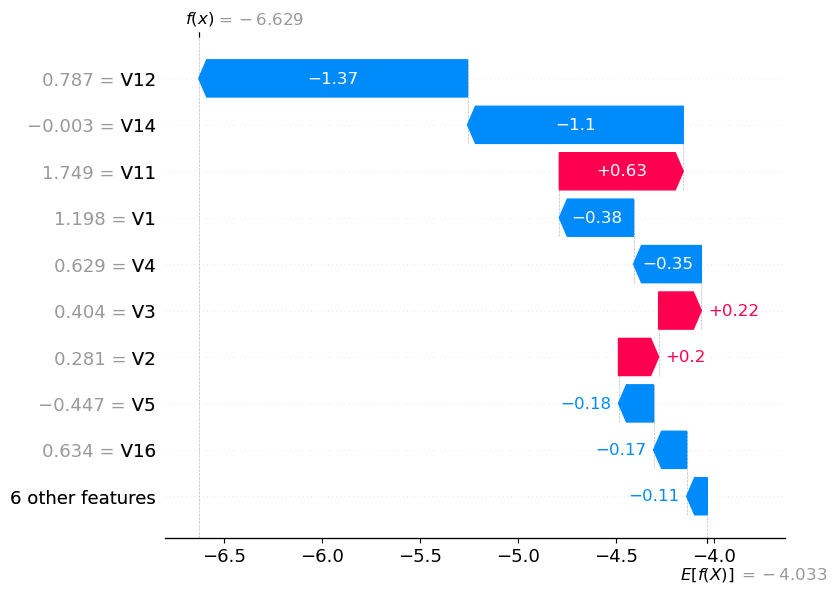

In [ ]:
# Plot the SHAP values for the first instance's positive class
shap.plots.waterfall(positive_class_shap_values[0])

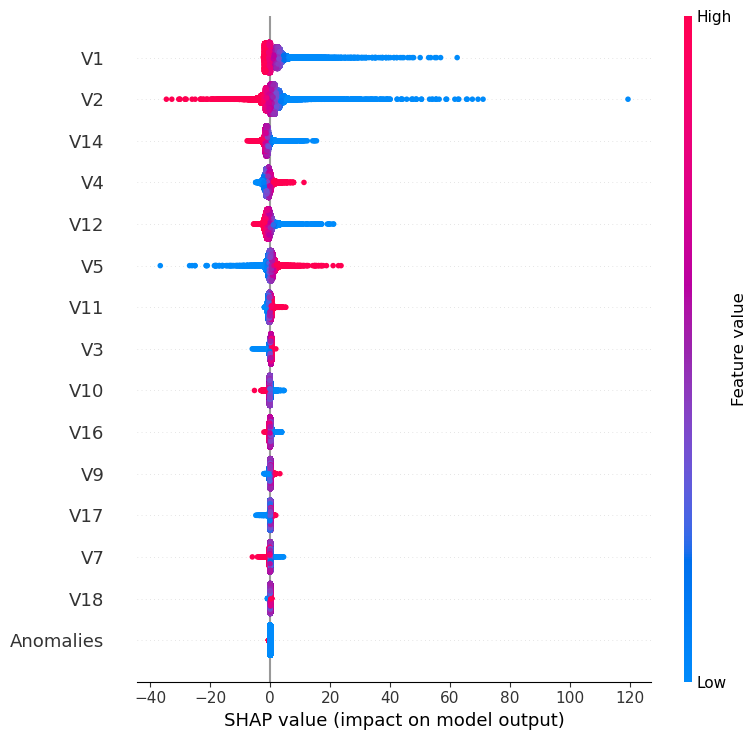

In [ ]:
shap.summary_plot(positive_class_shap_values, X_test)